In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
from torch import nn
import torchvision
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.job_output import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values
from ml_utilities.torch_models import get_model_config
from ml_utilities.data_utils import show_images

# 13.0.0 CIFAR10 Dataset & Model setup

This notebook is a debug notebook to create the config for CIFAR10 experiments and to do an initial hyperparameter tuning.


## 0. Load CIFAR10 dataset

In [2]:
data_dir = '/system/user/beck/pwbeck/data'

In [3]:
data_cfg = """
data:
  dataset: cifar10
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data
  dataset_split:
    train_val_split: 0.9
  dataset_transforms:
    image_transforms:
    - RandomHorizontalFlip
    - RandomCrop:
        size: 32
        padding: 4
    tensor_transforms: 
    joint_tensor_transforms: 
    enable_transforms: True
"""
data_cfg = OmegaConf.create(data_cfg)

In [4]:
from erank.data.datasetgenerator import DatasetGenerator
ds_generator = DatasetGenerator(**data_cfg.data)
ds_generator.generate_dataset()

Files already downloaded and verified


In [5]:
ds_generator.train_split.dataset

In [6]:
len(ds_generator.train_split), len(ds_generator.val_split)

(45000, 5000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


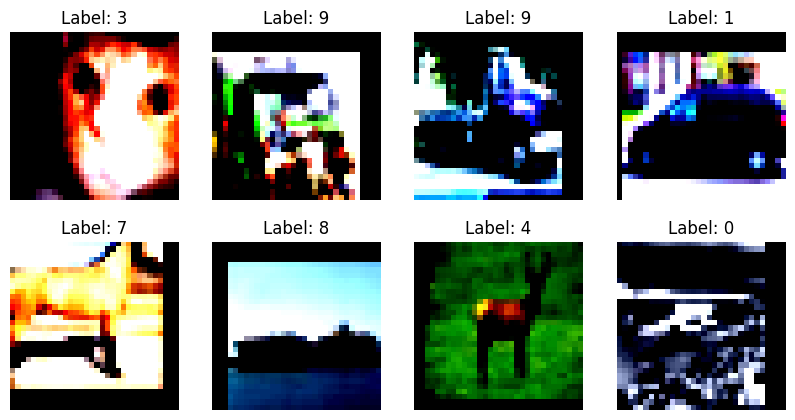

In [7]:
show_images(ds_generator.train_split, 10)

## 1. Load ResNet model

In [8]:
model_cfg = get_model_config('resnet20-cifar10')
print(OmegaConf.to_yaml(model_cfg))

name: resnet
model_kwargs:
  in_channels: 3
  act_fn: relu
  residual_option: A
  input_layer_config:
    kernel_size: 3
    out_channels: 16
    bias: false
    batch_norm: true
    stride: 1
    padding: 1
  resnet_blocks_config:
  - out_channels: 16
    num_residual_blocks: 3
  - out_channels: 32
    num_residual_blocks: 3
  - out_channels: 64
    num_residual_blocks: 3
  linear_output_units:
  - 10



In [9]:
from ml_utilities.torch_models.resnet import Resnet
resnet_model = Resnet(**model_cfg.model_kwargs)

In [10]:
from torchinfo import summary
summary(resnet_model, input_data=torch.randn(16, 3, 32, 32), depth=4)

Layer (type:depth-idx)                        Output Shape              Param #
Resnet                                        [16, 10]                  --
├─Sequential: 1-1                             [16, 10]                  --
│    └─Sequential: 2-1                        [16, 16, 32, 32]          --
│    │    └─Conv2d: 3-1                       [16, 16, 32, 32]          432
│    │    └─BatchNorm2d: 3-2                  [16, 16, 32, 32]          32
│    │    └─ReLU: 3-3                         [16, 16, 32, 32]          --
│    └─Sequential: 2-2                        [16, 64, 8, 8]            --
│    │    └─Sequential: 3-4                   [16, 16, 32, 32]          --
│    │    │    └─_ResidualBlock: 4-1          [16, 16, 32, 32]          4,672
│    │    │    └─_ResidualBlock: 4-2          [16, 16, 32, 32]          4,672
│    │    │    └─_ResidualBlock: 4-3          [16, 16, 32, 32]          4,672
│    │    └─Sequential: 3-5                   [16, 32, 16, 16]          --
│    │    

In [11]:
# optim = torch.optim.SGD(resnet_model.parameters(), lr=0.1)

# 13.0 CIFAR10 Standard Training influence Augmentation

## A. Experiment config

In [40]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [0]
  runs_per_gpu: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: data.dataset_transforms.enable_transforms
    vals: [True, False]
    
start_num: 0

config:
  experiment_data:
    entity: jkuiml-fsl
    project_name: tflearning
    experiment_tag: '13.0'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet-default_hp-aug
    experiment_dir: null
    experiment_notes: 
    job_name: null
    seed: 0
    hostname: null
    gpu_id: 0
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
    watch:
      log: null
      log_freq:

  model:
    model_cfg: resnet20-cifar10
    init_model: null

  trainer:
    training_setup: supervised
    n_steps: 64e3
    log_train_step_every: 1
    log_additional_train_step_every_multiplier: 1
    log_additional_logs: true
    val_every: 100
    save_every: 10000
    early_stopping_patience: 64e3
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.1
        momentum: 0.9
        weight_decay: 0.0001
      lr_scheduler_name: MultiStepLR
      lr_scheduler_kwargs:
        milestones: [32e3, 48e3]
        gamma: 0.1

    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4
    verbose: false
  data:
    dataset: cifar10
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
      # restrict_n_samples_train_task: 100
    dataset_transforms:
      image_transforms:
      - RandomHorizontalFlip
      - RandomCrop:
          size: 32
          padding: 4
      tensor_transforms: 
      joint_tensor_transforms: 
      enable_transforms: True
"""
cfg = OmegaConf.create(config_yaml)

In [41]:
run_command = REPO.create_experiment(cfg, override=True)
print(run_command)

python run_sweep.py --config-name cifar10-13.0.0-resnet-default_hp-aug.yaml


### Sweep result

In [ ]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

In [ ]:
# failed_jobs = sweepr.get_failed_jobs()
# failed_jobs # No failed jobs

## B. Analysis 1

In [ ]:
pprint(sweepr.available_log_columns)

In [ ]:
sw_summary = sweepr.get_summary()

In [ ]:
sw_summary

# 13.1 CIFAR 10 Hyperparameter search

In [44]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [1,2,3]
  runs_per_gpu: 2
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: trainer.optimizer_scheduler.optimizer_kwargs.lr
    vals: [1.0, 0.5, 0.01]
  - parameter: trainer.optimizer_scheduler.optimizer_kwargs.weight_decay
    vals: [0.0, 0.001, 0.005]
  - parameter: trainer.batch_size
    vals: [64, 256, 512]
    
start_num: 0

config:
  experiment_data:
    entity: jkuiml-fsl
    project_name: tflearning
    experiment_tag: '13.1'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet-default_hp-hypsearch
    experiment_dir: null
    experiment_notes: 
    job_name: null
    seed: 0
    hostname: null
    gpu_id: 0
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
    watch:
      log: null
      log_freq:

  model:
    model_cfg: resnet20-cifar10
    init_model: null

  trainer:
    training_setup: supervised
    n_steps: 64e3
    log_train_step_every: 1
    log_additional_train_step_every_multiplier: 1
    log_additional_logs: true
    val_every: 100
    save_every: 10000
    early_stopping_patience: 64e3
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.1
        momentum: 0.9
        weight_decay: 0.0001
      lr_scheduler_name: MultiStepLR
      lr_scheduler_kwargs:
        milestones: [32e3, 48e3]
        gamma: 0.1

    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4
    verbose: false
  data:
    dataset: cifar10
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
      # restrict_n_samples_train_task: 100
    dataset_transforms:
      image_transforms:
      - RandomHorizontalFlip
      - RandomCrop:
          size: 32
          padding: 4
      tensor_transforms: 
      joint_tensor_transforms: 
      enable_transforms: True
"""
cfg = OmegaConf.create(config_yaml)

In [45]:
run_command = REPO.create_experiment(cfg, override=True)
print(run_command)

python run_sweep.py --config-name cifar10-13.1.0-resnet-default_hp-hypsearch.yaml
